In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal, ndimage
import ncc
from IPython.display import Image as ImageIPy
from IPython.display import display

In [2]:
# Part 1
# Q2

def MakeGaussianPyramid(image, scale, minsize):
    """
    Return a Gaussian pyramid as a list of numpy arrays
    Inputs:
    - image: original PIL image
    - scale: scaling factor from one level to next
    - minsize: the minimum of the larger dimension of a pyramid image
    """
    
    # get a copy of the original image
    imageCpy = image.copy()
    
    # initialize spacial dimensions, mode ("L" or "RGB")
    width, height = imageCpy.size
    mode = imageCpy.mode
    
    # keep build the pyramid until minsize reached
    pyramid = []
    while max(width, height) >= minsize:
        # Convert to numpy array and append to list
        image_array = (np.asarray(imageCpy, dtype=np.float64)).copy()
        pyramid.append(image_array)
        
        # Compute width and height for the next level
        width = int(width*scale)
        height = int(height*scale)
        
        # Smooth and downsample
        if max(width, height) >= minsize:
            imageGFiltered_array = np.zeros(image_array.shape)
            if mode is "L":
                # for grayscale image, image_array is 2D
                imageGFiltered_array = ndimage.gaussian_filter(image_array, 1/(2.0*scale), order=0, mode='constant', cval=0.0) 
            else:
                # for RGB image, image_array is 3D, filter each chanel separately
                for channel in range(0, image_array.shape[2]):
                    imageGFiltered_array[:,:,channel] = ndimage.gaussian_filter(image_array[:,:,channel], 1/(2.0*scale), order=0, mode='constant', cval=0.0) 
            imageGFiltered = None
            imageGFiltered = Image.fromarray(imageGFiltered_array.astype('uint8'), mode=mode)
            imageCpy = imageGFiltered.resize((width, height), Image.BICUBIC)
            
    return pyramid

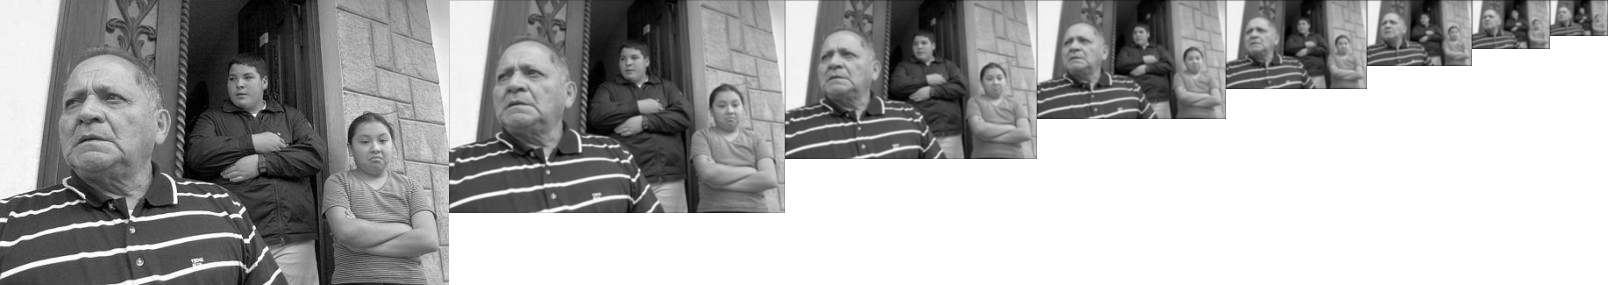

In [3]:
# Q3

def ShowGaussianPyramid(pyramid):
    """
    Join all images in the given pyramid into one horizontal image
    and display it.
    Inputs:
    - pyramid: A non-empty pyramid as a list of numpy arrays
    """
    # compute canvas width and height
    width = 0
    height = pyramid[0].shape[0]
    for image_array in pyramid:
        width = width + image_array.shape[1]
    
    # create canvas
    mode = 'L'
    if pyramid[0].ndim == 3:
        mode = 'RGB'
    canvas = None
    if mode == 'L':
        canvas = Image.new(mode, (width, height), color=255)
    else:
        canvas = Image.new(mode, (width, height), color='white')
    # copy images in pyramid to canvas
    offset_x = offset_y = 0
    for image_array in pyramid:
        image = Image.fromarray(image_array.astype('uint8'), mode=mode)
        canvas.paste(image, (offset_x, offset_y))
        offset_x = offset_x + image.size[0]
    
    # save and display the final image
    canvas.save('gaussianPyramid.png', 'png')
    display(ImageIPy(filename='gaussianPyramid.png'))
    return


imageQ3 = Image.open('/home/eric/dev_cpsc425/asst2/hw2part1/faces/family.jpg')
pyramid = MakeGaussianPyramid(imageQ3, 0.75, 50)
ShowGaussianPyramid(pyramid)

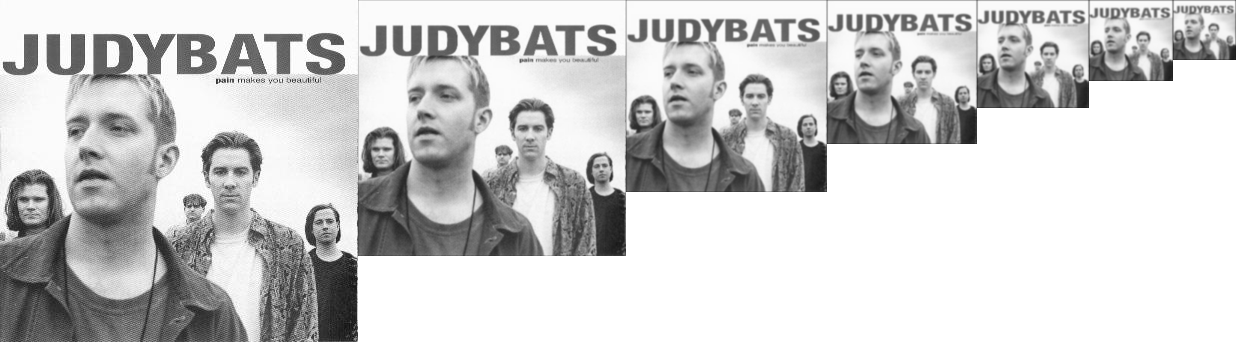

/home/eric/dev_cpsc425/asst2/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


Template found near (325, 225)
Template found near (301, 85)
Template found near (303, 85)
Template found near (304, 85)
Template found near (29, 204)
Template found near (30, 204)
Template found near (32, 204)
Template found near (33, 204)
Template found near (34, 204)
Template found near (30, 205)
Template found near (32, 205)
Template found near (323, 225)
Template found near (324, 225)
Template found near (325, 225)
Template found near (324, 227)
Template found near (325, 227)
Template found near (229, 176)
Template found near (231, 176)
Template found near (228, 178)
Template found near (229, 178)
Template found near (231, 178)
Template found near (225, 178)
Template found near (228, 178)
Template found near (230, 178)
Template found near (232, 178)
Template found near (225, 180)
Template found near (228, 180)
Template found near (230, 180)
Template found near (232, 180)
Template found near (228, 182)
Template found near (230, 182)
Template found near (92, 139)
Template found near

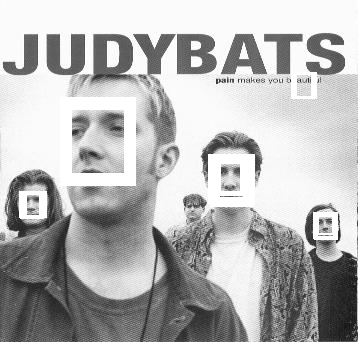

In [4]:
# Q4

def IdentifyCorners(loc_ctr, size_image, size_template):
    """
    Return the four corner pixels of a neighborhood centred
    at loc_ctr. The corner pixels are bounded within the image
    and their locations are in (x, y).
    Inputs:
    - loc_ctr: Centre pixel location (x, y)
    - size_image: image size in width x height
    - size_template: template size in width x height
    """
    width_image, height_image = size_image
    width_template, height_template = size_template
    
    # initialize corner positions
    c0 = [0, 0]
    c1 = [0, 0]
    c2 = [0, 0]
    c3 = [0, 0]
    
    # set x positions
    if width_template % 2 == 1:
        c0[0] = c3[0] = loc_ctr[0] - math.floor(width_template/2)
        c1[0] = c2[0] = loc_ctr[0] + math.floor(width_template/2)
    else:
        c0[0] = c3[0] = loc_ctr[0] - (width_template/2)
        c1[0] = c2[0] = loc_ctr[0] + (width_template/2) - 1
    
    # set y positions
    if height_template % 2 == 1:
        c0[1] = c1[1] = loc_ctr[1] - math.floor(height_template/2)
        c2[1] = c3[1] = loc_ctr[1] + math.floor(height_template/2)
    else:
        c0[1] = c1[1] = loc_ctr[1] - height_template/2
        c2[1] = c3[1] = loc_ctr[1] + height_template/2 - 1
    
    # bound corner positions by image size
    # idea from https://stackoverflow.com/questions/22367854/how-do-i-bound-a-number-between-two-constants-using-the-modulus-operator
    for loc_corner in [c0, c1, c2, c3]:
        if loc_corner[0] < 0 or loc_corner[0] >= width_image:
            loc_corner[0] = max(0, min(width_image-1, loc_corner[0]))
        if loc_corner[1] <0 or loc_corner[1] >= height_image:
            loc_corner[1] = max(0, min(height_image-1, loc_corner[1]))
    
    return (c0, c1, c2, c3)

def MarkBoundaries(image, size_template, nccBin_array):
    """
    Mark boundaries of qualified neighborhoods.
    Returns a bounding-box image as a 1D numpy array, with each
    value in {0, 1} indicating if it is a boundary pixel or not.
    Inputs:
    - image: a PIL image of dimension (w, h)
    - size_template: size of template in width x height
    - nccBin_array: a numpy array of dimension (h, w) of values
      in {0, 255} which indicate if the NCC result at a pixel is
      above threshold or not.
    """
    # initialize marked image
    imageMarked_array = np.zeros((image.size[1], image.size[0]))
    imageMarked = Image.fromarray(imageMarked_array.astype('uint8'))
    
    # iterate over each pixel to draw boundaries for qualified
    # neighborhoods
    draw = ImageDraw.Draw(imageMarked)
    width_image, height_image = image.size
    width_template, height_template = size_template
    for row in range(0, height_image):
        for col in range(0, width_image):
            if nccBin_array[row, col] == 1:
                # identify corner pixels of neighborhood
                corner_pixels = IdentifyCorners((col, row), image.size, size_template)
                c0, c1, c2, c3 = corner_pixels
                # draw lines to connect corner pixels
                draw.line((c0[0],c0[1],c1[0],c1[1]),fill="white",width=2)
                draw.line((c1[0],c1[1],c2[0],c2[1]),fill="white",width=2)
                draw.line((c2[0],c2[1],c3[0],c3[1]),fill="white",width=2)
                draw.line((c3[0],c3[1],c0[0],c0[1]),fill="white",width=2)
    del draw
    
    imageMarked_array = (np.asarray(imageMarked, dtype=np.float64)).copy()    
    return imageMarked_array


def OverlayWhitePixels(canvas_array, imageMarked_array):
    """
    Mark a pixel on the canvas white, if its corresponding pixel
    in the marked image has been painted black.
    Inputs:
    - canvas_array: canvas as a (h, w) numpy array.
    - imageMarked_array: marked image as a (h', w') numpy array.
    """
    
    # enlarge the marked image to the size of the canvas
    imageMarked = Image.fromarray(imageMarked_array.astype('uint8'))
    #imageMarked.show()
    imageMarkedEnlarged = imageMarked.resize((canvas_array.shape[1], canvas_array.shape[0]))
    
    # Correspond pixels marked as boundary and overlay to canvas
    for row in range(0, canvas_array.shape[0]):
        for col in range(0, canvas_array.shape[1]):
            # if marked as boundary, paint white
            if imageMarkedEnlarged.getpixel((col, row)) > 250:
                canvas_array[row, col] = 255.0
            
    return None


def FindTemplate(pyramid, template, threshold):
    """ 
    Find and mark all locations in the given pyramid where
    the NCC of the template and an image is above the threshold.
    Returns a tuple including 1) the marked original image as a
    numpy array; 2) number of templates found.
    Inputs:
    - pyramid: image pyramid as a non-empty list of numpy arrays
    - template: template as a numpy array
    - threshold: a floating point value in [-1, 1]
    """
    # set up canvas (the original image) as a 3D numpy array
    canvas = Image.fromarray(pyramid[0].astype('uint8'))
    canvas_array = (np.asarray(canvas, dtype=np.float64)).copy()
    
    # iterate over each image in pyramid
    num_positives = 0
    for image in pyramid:
        # do NCC
        image_PIL = Image.fromarray(image.astype('uint8'))
        template_PIL = Image.fromarray(template.astype('uint8'))
        ncc_array = ncc.normxcorr2D(image_PIL, template_PIL)
        # find locations in NCC where value > threshold
        nccBin_array = ncc_array > threshold
        # report locations of qualified neighborhoods
        resizeRatio = float(pyramid[0].shape[0]) / image.shape[0]
        for row in range(0, nccBin_array.shape[0]):
            for col in range(0, nccBin_array.shape[1]):
                if nccBin_array[row, col]:
                    y = int(resizeRatio * row)
                    x = int(resizeRatio * col)
                    print(f"Template found near ({x}, {y})")
        # mark boundaries of qualified neighborhoods
        imageMarked_array = MarkBoundaries(image_PIL, template_PIL.size, nccBin_array)
        # find pixels marked as boundary, and overlay them onto the canvas array
        OverlayWhitePixels(canvas_array, imageMarked_array)
        # accumulate positives
        num_positives = num_positives + np.sum(nccBin_array)
    
    return (canvas_array, num_positives)


# generate pyramid
imageQ4 = Image.open('/home/eric/dev_cpsc425/asst2/hw2part1/faces/judybats.jpg')
pyramidQ4 = MakeGaussianPyramid(imageQ4, 0.75, 50)
ShowGaussianPyramid(pyramidQ4)

# set up template
templateQ4 = Image.open('/home/eric/dev_cpsc425/asst2/face_detection_template.jpg')
width_template = 15
templateQ4AspectRatio = float(width_template)/templateQ4.size[0]
templateQ4Resized = templateQ4.resize((width_template, int(templateQ4AspectRatio*templateQ4.size[1])), Image.BICUBIC)
templateQ4Resized_array = (np.asarray(templateQ4Resized, dtype=np.float64)).copy()

# find matches
thresholdQ4 = 0.6
imageQ4Matched_array, _ = FindTemplate(pyramidQ4, templateQ4Resized_array, thresholdQ4)
imageQ4Matched = Image.fromarray(imageQ4Matched_array.astype('uint8'))
imageQ4Matched.save('q4.png', 'png')
display(ImageIPy(filename='q4.png'))

Showing result for /home/eric/dev_cpsc425/asst2/hw2part1/faces/fans.jpg:
Template found near (204, 150)
Template found near (205, 150)
Template found near (206, 150)
Template found near (207, 150)
Template found near (208, 150)
Template found near (224, 150)
Template found near (225, 150)
Template found near (226, 150)
Template found near (227, 150)
Template found near (228, 150)
Template found near (229, 150)
Template found near (230, 150)
Template found near (231, 150)
Template found near (232, 150)
Template found near (225, 57)
Template found near (227, 57)
Template found near (230, 57)
Template found near (222, 59)
Template found near (225, 59)
Template found near (227, 59)
Template found near (230, 59)
21 templates found;


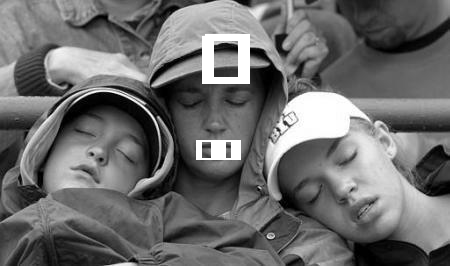

Showing result for /home/eric/dev_cpsc425/asst2/hw2part1/faces/sports.jpg:
0 templates found;


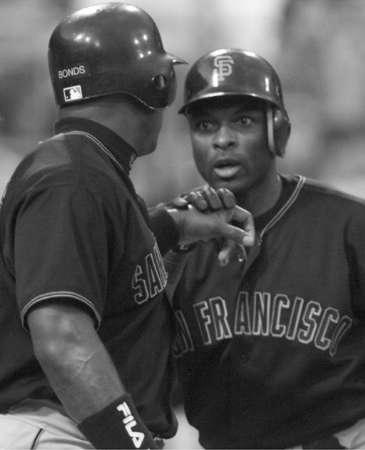

Showing result for /home/eric/dev_cpsc425/asst2/hw2part1/faces/tree.jpg:
Template found near (380, 214)
Template found near (381, 214)
2 templates found;


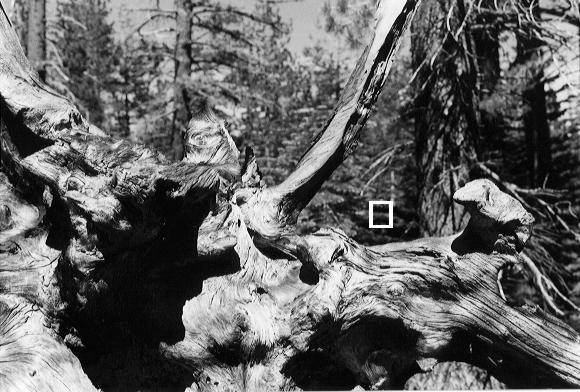

Showing result for /home/eric/dev_cpsc425/asst2/hw2part1/faces/judybats.jpg:
Template found near (303, 85)
Template found near (29, 204)
Template found near (30, 204)
Template found near (32, 204)
Template found near (33, 204)
Template found near (34, 204)
Template found near (30, 205)
Template found near (32, 205)
Template found near (324, 225)
Template found near (325, 225)
Template found near (324, 227)
Template found near (228, 178)
Template found near (229, 178)
Template found near (231, 178)
Template found near (225, 178)
Template found near (228, 178)
Template found near (230, 178)
Template found near (225, 180)
Template found near (228, 180)
Template found near (230, 180)
Template found near (232, 180)
Template found near (228, 182)
Template found near (230, 182)
Template found near (92, 139)
Template found near (97, 139)
Template found near (92, 143)
Template found near (97, 143)
27 templates found;


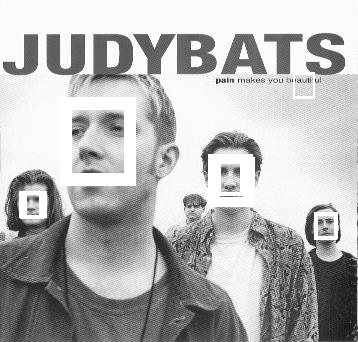

Showing result for /home/eric/dev_cpsc425/asst2/hw2part1/faces/students.jpg:
Template found near (279, 19)
Template found near (42, 35)
Template found near (240, 39)
Template found near (241, 39)
Template found near (242, 39)
Template found near (344, 53)
Template found near (93, 78)
Template found near (344, 113)
Template found near (345, 113)
Template found near (346, 113)
Template found near (347, 113)
Template found near (344, 114)
Template found near (345, 114)
Template found near (346, 114)
Template found near (347, 114)
Template found near (127, 115)
Template found near (128, 115)
Template found near (129, 115)
Template found near (127, 116)
Template found near (128, 116)
Template found near (129, 116)
Template found near (215, 223)
Template found near (216, 223)
Template found near (40, 36)
Template found near (41, 36)
Template found near (42, 36)
Template found near (238, 40)
Template found near (240, 40)
Template found near (241, 40)
Template found near (144, 44)
Template fou

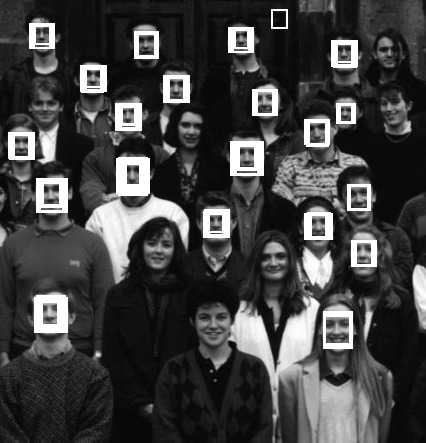

Showing result for /home/eric/dev_cpsc425/asst2/hw2part1/faces/family.jpg:
Template found near (376, 146)
Template found near (378, 146)
Template found near (92, 108)
Template found near (96, 108)
Template found near (90, 112)
Template found near (95, 112)
6 templates found;


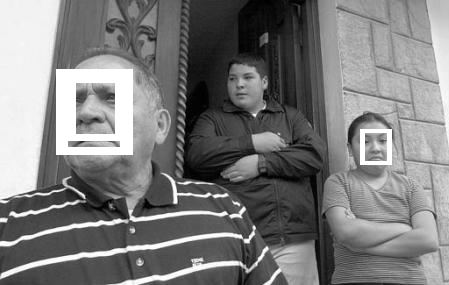

In [5]:
# Q5
import os
import glob

def DetectFace(filePath_image, filePath_template, scale, heightMin_image, width_template, threshold):
    """
    Run detection on the given image using the given template. Display
    and save the detection result. Return and display number of templates 
    detected.
    Inputs:
    - filePath_image: absolute path to image
    - filePath_template: absolute path to template
    - scale: scaling factor to construct pyramid
    - heightMin_image: min height of image
    - width_template: width of template
    - threshold: threshold for NCC, should be in [-1, 1]
    """
    # generate pyramid
    image = Image.open(filePath_image)
    pyramid = MakeGaussianPyramid(image, scale, heightMin_image)
    #ShowGaussianPyramid(pyramid)
    
    # set up template
    template = Image.open(filePath_template)
    templateAspectRatio = float(width_template)/template.size[0]
    templateResized = template.resize((width_template, int(templateAspectRatio*template.size[1])), Image.BICUBIC)
    templateResized_array = (np.asarray(templateResized, dtype=np.float64)).copy()
    
    print(f"Showing result for {filePath_image}:")
    
    # find matches
    imageMatched_array, num_positives = FindTemplate(pyramid, templateResized_array, threshold)
    imageMatched = Image.fromarray(imageMatched_array.astype('uint8'))
    
    # save and display result
    print(f"{num_positives} templates found;")
    fileName_image = os.path.basename(filePath_image)
    fileName_result = fileName_image.rstrip('.jpg') + '_result' + '.png'
    imageMatched.save(fileName_result, 'png')
    display(ImageIPy(filename=fileName_result))
    return num_positives


for filePath_image in glob.glob(f'/home/eric/dev_cpsc425/asst2/hw2part1/faces/*.jpg'):
    DetectFace(filePath_image, '/home/eric/dev_cpsc425/asst2/face_detection_template.jpg', 0.75, 50, 15, 0.615)

Q5

For the threshold in the previous question (0.615), False positives, False negatives:
1. fans: 7 , 2
2. sports: 0, 1
3. tree: 2, 0
4. judybats: 1, 1
5. students: 1, 7
6. family: 0, 1
* Total: 11, 12

In [6]:
# Q6

def compute_recall(tp, fn):
    """
    Returns recall given true positives and false negatives.
    """
    if (tp+fn) != 0:
        return (tp/(tp+fn))
    else:
        # based on info found in https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-denominators-equal-0
        return 1


print("Recalls:")
for filePath_result in glob.glob(f'/home/eric/dev_cpsc425/asst2/*_result.png'):
    if 'fans' in filePath_result:
        print(f"{filePath_result}: {compute_recall(1, 2)}")
    elif 'sports' in filePath_result:
        print(f"{filePath_result}: {compute_recall(0, 1)}")
    elif 'tree' in filePath_result:
        print(f"{filePath_result}: undefined")
    elif 'judybats' in filePath_result:
        print(f"{filePath_result}: {compute_recall(4, 1)}")
    elif 'students' in filePath_result:
        print(f"{filePath_result}: {compute_recall(20, 7)}")
    elif 'family' in filePath_result:
        print(f"{filePath_result}: {compute_recall(2, 1)}")

Recalls:
/home/eric/dev_cpsc425/asst2/fans_result.png: 0.3333333333333333
/home/eric/dev_cpsc425/asst2/judybats_result.png: 0.8
/home/eric/dev_cpsc425/asst2/tree_result.png: undefined
/home/eric/dev_cpsc425/asst2/family_result.png: 0.6666666666666666
/home/eric/dev_cpsc425/asst2/sports_result.png: 0.0
/home/eric/dev_cpsc425/asst2/students_result.png: 0.7407407407407407


Out of the six images, "fans" and "sports" have low recall, both due to zero true positives. This is possibly because:
1. In "fans", for the two faces on the sides, their poses relative to camera are different from faces in other images that are slightly turned to right or facing straight forward. The face in the middle is partially occluded by a hat.
2. In "sports", the face is partially occluded by a hat. The lighting condition also seems to be different from the template - the hat casts a shadow on the face. Also, the template may be biased such that it performs poorly on faces of some ethnicities.

In [7]:
# Part 2

#Q2
def MakeLaplacianPyramid(image, scale, minsize):
    """
    Create a Laplacian pyramid for the given image. Return the
    pyramid.
    Inputs:
    - image: original PIL image
    - scale: scale factor from one level to next
    - minsize: the minimum of the larger dimension of a pyramid image
    """
    # build Gaussian pyramid
    pyramidGaussian = MakeGaussianPyramid(image, scale, minsize)
    pyramidLap = []
    
    # case 1: Gaussian pyramid is empty or contains only one level
    if len(pyramidGaussian) <= 1:
        pyramidLap = pyramidGaussian
    
    # case 2: Guassian pyramid contains >=2 levels
    else:
        # filter and compute residuals
        pyramidLap = []
        assert len(pyramidGaussian)>=1
        for i in range(0, len(pyramidGaussian)-1):
            # get unfiltered image F_i
            imageF_array = pyramidGaussian[i]
            imageI_array = np.zeros(imageF_array.shape)
            # get filtered image I_i
            for channel in range(0, imageF_array.shape[2]):
                imageI_array[:,:,channel] = ndimage.gaussian_filter(imageF_array[:,:,channel], 1/(2.0*scale), order=0, mode='constant', cval=0.0)
            # compute residual H_i
            imageH_array = imageF_array - imageI_array
            pyramidLap.append(imageH_array)
        # append the highest level of the Gaussian pyramid
        pyramidLap.append(pyramidGaussian[-1])
        assert len(pyramidGaussian) == len(pyramidLap)
        
    return pyramidLap

Showing Laplacian pyramid for orchid.jpg:


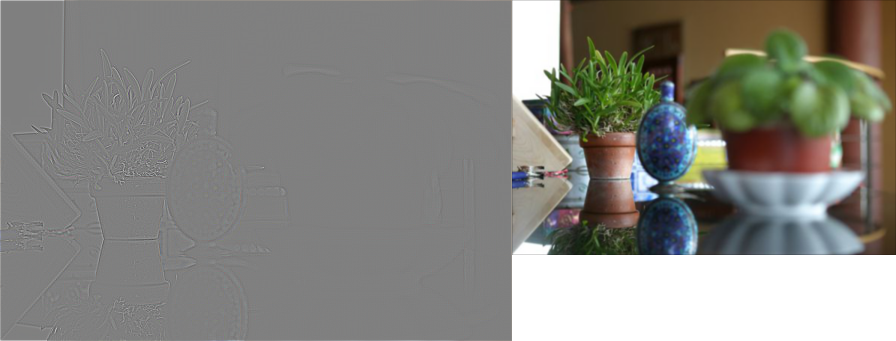

Showing Laplacian pyramid for violet.jpg:


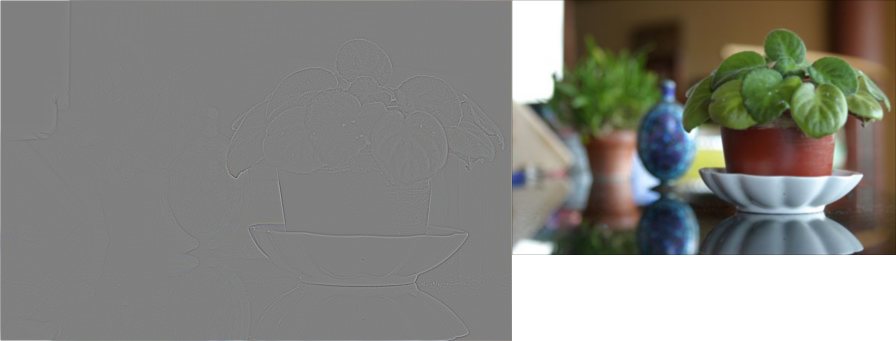

In [8]:
# Q3

def ShowLaplacianPyramid(pyramid):
    """
    Join all images in the given pyramid into one horizontal image
    and display it.
    Inputs:
    - pyramid: A non-empty Laplacian pyramid as a list of numpy
      arrays
    """
    # compute canvas width and height
    width = 0
    height = pyramid[0].shape[0]
    for image_array in pyramid:
        width = width + image_array.shape[1]
    
    # copy images in pyramid to canvas
    canvas = Image.new("RGB", (width, height), color="white")
    offset_x = offset_y = 0
    for i in range(0, len(pyramid)):
        image_array = pyramid[i]
        # for non-last levels, map to [0, 255]
        if i != len(pyramid)-1:
            image_array = np.clip((image_array + 128.0), 0.0, 255.0)
        image = Image.fromarray(image_array.astype('uint8'))
        canvas.paste(image, (offset_x, offset_y))
        offset_x = offset_x + image.size[0]
    
    # save and display the final image
    canvas.save('laplacianPyramid.png', 'png')
    display(ImageIPy(filename='laplacianPyramid.png'))
    return
    return None


imagePt2Q3Orchid = Image.open('/home/eric/dev_cpsc425/asst2/hw2part2/orchid.jpg')
pyramidPt2Q3Orchid = MakeLaplacianPyramid(imagePt2Q3Orchid, 0.75, 300)
print("Showing Laplacian pyramid for orchid.jpg:")
ShowLaplacianPyramid(pyramidPt2Q3Orchid)

imagePt2Q3Violet = Image.open('/home/eric/dev_cpsc425/asst2/hw2part2/violet.jpg')
pyramidPt2Q3Violet = MakeLaplacianPyramid(imagePt2Q3Violet, 0.75, 300)
print("Showing Laplacian pyramid for violet.jpg:")
ShowLaplacianPyramid(pyramidPt2Q3Violet)

Showing orchid's Gaussian pyramid (reconstructed):


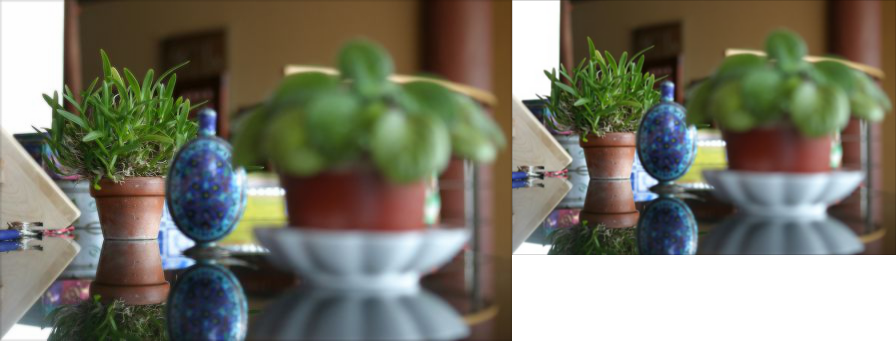

Showing violet's Gaussian pyramid (reconstructed):


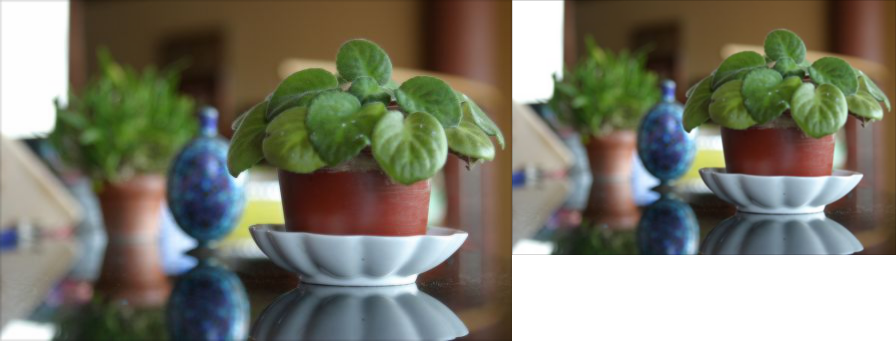

In [9]:
# Q4

def ReconstructGaussianFromLaplacianPyramid(lPyramid):
    """
    Reconstruct Gaussian pyramid from Laplacian pyramid.
    Inputs:
    - lPyramid: a Laplacian pyramid as a list of 3D numpy arrays
      length should be >=2 to deduce scaling factor
    """
    
    assert len(lPyramid) >= 2
    
    # compute scaling factor
    scale = lPyramid[1].shape[0] / lPyramid[0].shape[0]
    
    # append the highest level of Laplacian
    # to Gaussian
    gPyramid = []
    gPyramid.append(lPyramid[-1])
    
    # reconstruct lower levels
    for levelLap in range(len(lPyramid)-2, -1, -1):
        # get residual from Laplacian pyramid
        imageLap_array = lPyramid[levelLap]
        
        # upsample last level of Gaussian pyramid and blurr
        imageFLast_array = gPyramid[0]
        imageFLast = Image.fromarray(imageFLast_array.astype('uint8'))
        imageFLastUpsampled = imageFLast.resize((imageLap_array.shape[1], imageLap_array.shape[0]), Image.BICUBIC)
        imageFLastUpsampled_array = np.asarray(imageFLastUpsampled, dtype=np.float64)
        imageFLastBlurred_array = np.zeros(imageFLastUpsampled_array.shape)
        for channel in range(0, imageFLastUpsampled_array.shape[2]):
            imageFLastBlurred_array[:,:,channel] = ndimage.gaussian_filter(imageFLastUpsampled_array[:,:,channel], 1/(2.0*scale), order=0, mode='constant', cval=0.0)
        
        # sum with residual from Laplacian pyramid
        imageFCurr_array = imageFLastBlurred_array + imageLap_array         
        
        # insert reconstructed image to front
        gPyramid.insert(0, imageFCurr_array)
    
    assert len(gPyramid) == len(lPyramid)
    
    return gPyramid


# Reconstruct Gaussian pyramids and save the lowest levels
pyramidPt2Q4Orchid = ReconstructGaussianFromLaplacianPyramid(pyramidPt2Q3Orchid)
print("Showing orchid's Gaussian pyramid (reconstructed):")
ShowGaussianPyramid(pyramidPt2Q4Orchid)
Image.fromarray(np.clip(pyramidPt2Q4Orchid[0], 0.0, 255.0).astype('uint8')).save('orchid_reconstructed.png', 'png')
pyramidPt2Q4Violet = ReconstructGaussianFromLaplacianPyramid(pyramidPt2Q3Violet)
print("Showing violet's Gaussian pyramid (reconstructed):")
ShowGaussianPyramid(pyramidPt2Q4Violet)
Image.fromarray(np.clip(pyramidPt2Q4Violet[0], 0.0, 255.0).astype('uint8')).save('violet_reconstructed.png', 'png')

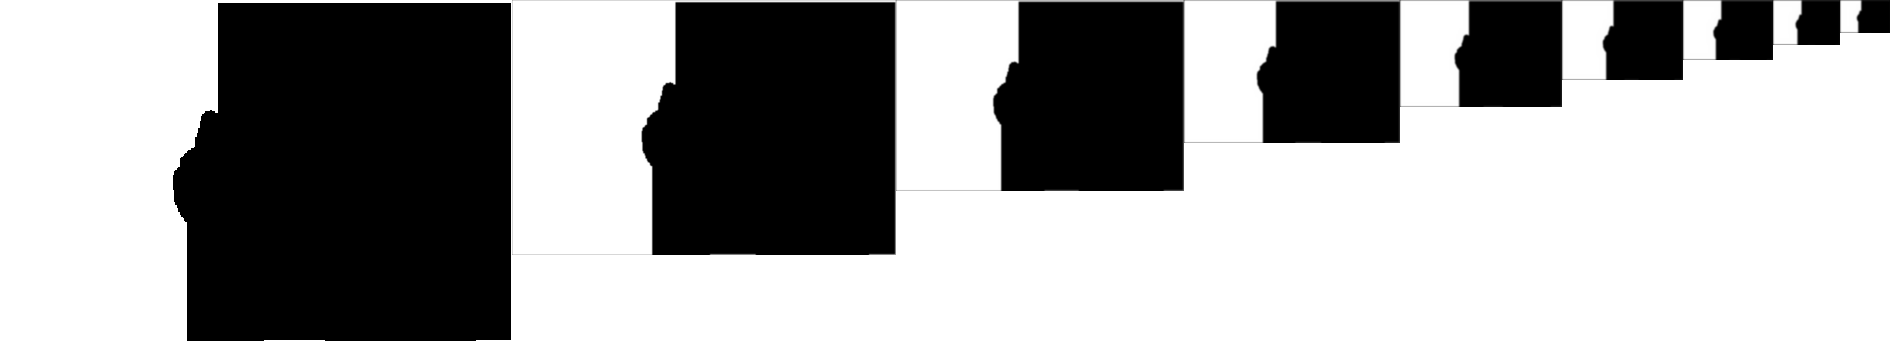

In [10]:
# Q5

imagePt2Q5 = Image.open('/home/eric/dev_cpsc425/asst2/hw2part2/orchid_mask.bmp')
pyramidPt2Q5 = MakeGaussianPyramid(imagePt2Q5, 0.75, 50)
ShowGaussianPyramid(pyramidPt2Q5)

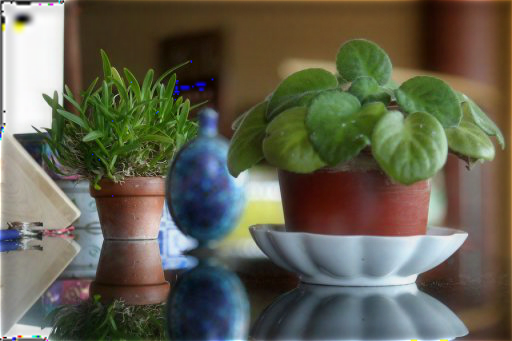

In [17]:
# Q6

def UpsampleAndBlurr(image_array, width, height, sigma):
    """
    Upsample the given image to height x width, then blurr with
    a Gaussian filter with sigma.
    Return the result image as a 3D numpy array
    Inputs:
    - image_array: a 3D numpy array
    - width: destination width
    - height: destination height
    - sigma: sigma of the applied Gaussian filter
    """
    image = Image.fromarray(image_array.astype('uint8'))
    imageUpsampled = image.resize((width, height), Image.BICUBIC)
    imageUpsampled_array = np.asarray(imageUpsampled, dtype=np.float64)
    #imageBlurred_array = np.zeros(imageUpsampled_array.shape)
    #for channel in range(0, imageUpsampled_array.shape[2]):
    #    imageBlurred_array[:,:,channel] = ndimage.gaussian_filter(imageUpsampled_array[:,:,channel], sigma, order=0, mode='constant', cval=0.0)
    return np.clip(imageUpsampled_array, 0.0, 255.0)


def BlendImages(filePath_imgA, filePath_imgB, filePath_mask, scale, minSize):
    """
    Return the blended output of the two given images
    and the mask, as a PIL image.
    Require image A, B and the mask image to have the
    exact same dimensions.
    Inputs:
    - filePath_imgA: path to image A
    - filePath_imgB: path to image B
    - filePath_mask: path to mask image
    - scale: scaling factor for pyramids
    - minSize: min of the larger dimension for constructing image and mask pyramids
    """
    # Build Laplacian pyramids for image A & B
    imageA = Image.open(filePath_imgA)
    imageB = Image.open(filePath_imgB)
    lPyramidA = MakeLaplacianPyramid(imageA, scale, minSize)
    lPyramidB = MakeLaplacianPyramid(imageB, scale, minSize)
    assert len(lPyramidA)==len(lPyramidB)
    
    # Build Gaussian pyramid GR for the mask image R
    imageM = Image.open(filePath_mask)
    gPyramidM = MakeGaussianPyramid(imageM, scale, minSize)
    # expand mask pyramid to 3 dimensions. Implementation
    # idea from https://stackoverflow.com/questions/32171917/copy-2d-array-into-3rd-dimension-n-times-python
    gPyramidM3D = []
    for gImageM in gPyramidM:
        gImageM = np.repeat(gImageM[:, :, np.newaxis], 3, axis=2)
        gPyramidM3D.append(gImageM)
    
    # Build combined Laplacian pyramid LS
    lPyramidComp = []
    for i in range(0, len(lPyramidA)-1):
        lPyramidCompLevelI = lPyramidA[i] * gPyramidM3D[i]/255.0 + lPyramidB[i] * (1 - gPyramidM3D[i]/255.0)
        lPyramidComp.append(lPyramidCompLevelI)
    assert len(lPyramidComp)==len(lPyramidA)-1 and len(lPyramidComp)==len(gPyramidM)-1
    
    # Build the spline (blended) image S by summing levels of LS
    # we need highest levels from Gaussian pyramids of image A & B
    gPyramidA = MakeGaussianPyramid(imageA, scale, minSize)
    gPyramidB = MakeGaussianPyramid(imageB, scale, minSize)
    assert len(gPyramidA)==len(lPyramidComp)+1 and len(gPyramidB)==len(lPyramidComp)+1
    # initialize image S
    imageS_array = None
    # sum up starting from the last level of combined Laplacian
    for levelComp in range(len(lPyramidComp)-1, -1, -1):
        # for the first step, we use low-freq components from A and B
        if levelComp == len(lPyramidComp)-1:
            # upsample last levels of Gaussian pyramids of A, B and blurr
            imageALast_array = gPyramidA[-1]
            imageAUpsampBlurred_array = UpsampleAndBlurr(imageALast_array, lPyramidComp[levelComp].shape[1], lPyramidComp[-1].shape[0], 1/(2.0*scale))
            imageBLast_array = gPyramidB[-1]
            imageBUpsampBlurred_array = UpsampleAndBlurr(imageBLast_array, lPyramidComp[levelComp].shape[1], lPyramidComp[-1].shape[0], 1/(2.0*scale))
            # apply mask to upsampled last levels and combine
            imageAB_array = imageAUpsampBlurred_array * gPyramidM3D[levelComp]/255.0 + imageBUpsampBlurred_array * (1 - gPyramidM3D[levelComp]/255.0)
            # sum with residual from Laplacian pyramid
            imageS_array = imageAB_array + lPyramidComp[levelComp]
        # for steps afterwards, we use low-freq components from itself
        else:
            # upsample and blurr image from last level
            imageSLastUpsampBlurred_array = UpsampleAndBlurr(imageS_array, lPyramidComp[levelComp].shape[1], lPyramidComp[levelComp].shape[0], 1/(2.0*scale))
            # sum with residual from Laplacian pyramid
            imageS_array = imageSLastUpsampBlurred_array + lPyramidComp[levelComp]
    
    # build image S in PIL format
    imageS = Image.fromarray(np.clip(imageS_array, 0.0, 255.0).astype('uint8'))
    assert imageS.size[0]==imageA.size[0] and imageS.size[1]==imageA.size[1]
    return imageS


imageOrchidViolet = BlendImages('/home/eric/dev_cpsc425/asst2/hw2part2/orchid.jpg', '/home/eric/dev_cpsc425/asst2/hw2part2/violet.jpg', '/home/eric/dev_cpsc425/asst2/hw2part2/orchid_mask.bmp', 0.75, 50)
imageOrchidViolet.save('orchid_violet.png', 'png')
display(ImageIPy(filename='orchid_violet.png'))

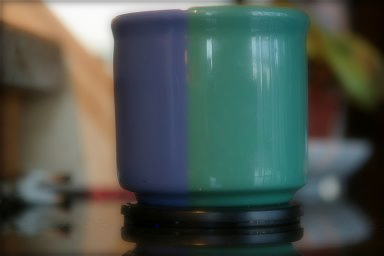

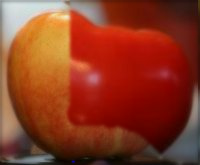

In [12]:
# Q7

# Blend blue and green cup
imageBlueGreenCup = BlendImages('/home/eric/dev_cpsc425/asst2/hw2part2/blue_cup.jpg', '/home/eric/dev_cpsc425/asst2/hw2part2/green_cup.jpg', '/home/eric/dev_cpsc425/asst2/hw2part2/cup_mask.bmp', 0.75, 75)
imageBlueGreenCup.save('blue_cup_green_cup.png', 'png')
display(ImageIPy(filename='blue_cup_green_cup.png'))

# Blend apple and tomato
imageAppleTomato = BlendImages('/home/eric/dev_cpsc425/asst2/hw2part2/apple.jpg', '/home/eric/dev_cpsc425/asst2/hw2part2/tomato.jpg', '/home/eric/dev_cpsc425/asst2/hw2part2/tomato_mask.bmp', 0.75, 75)
imageAppleTomato.save('apple_tomato.png', 'png')
display(ImageIPy(filename='apple_tomato.png'))